# Hotkeys  
- `A`, `B` front and back
- `ESC`, `ENTER` writing or commands
- `M`, `Y` md and code 


# Examples


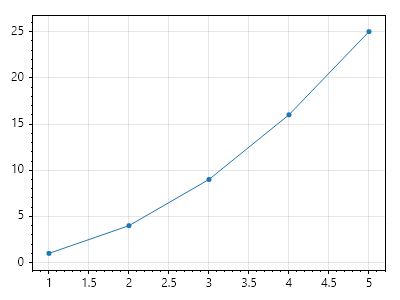

In [47]:
ScottPlot.Plot myPlot = new();

double[] dataX = { 1, 2, 3, 4, 5 };
double[] dataY = { 1, 4, 9, 16, 25 };
myPlot.Add.Scatter(dataX, dataY);
myPlot.GetImageBytes(400, 300, ScottPlot.ImageFormat.Png);
myPlot

# Start

In [42]:
#r "nuget:Microsoft.Data.Analysis"
#r "nuget:ScottPlot"

using Microsoft.Data.Analysis;
using System.Reflection;

Installed Packages Microsoft.Data.Analysis, 0.21.1 ScottPlot, 5.0.36

In [43]:
using Microsoft.DotNet.Interactive.Formatting;
Formatter.Register(typeof(ScottPlot.Plot), (p, w) => w.Write(((ScottPlot.Plot)p).GetImageHtml(400, 300)), HtmlFormatter.MimeType);

In [41]:
static DataFrame CreateDataFrame<T> (List<T> objects) {
    Type type = typeof(T);
    FieldInfo[] fields = type.GetFields(BindingFlags.Public | BindingFlags.Instance);
    
    var names = fields.Select(f => (f.Name, f.FieldType)).ToList();
    var boxed = objects.Select(item => fields.Select(f => f.GetValue(item)).ToList());

    return DataFrame.LoadFrom(boxed, names);
}

# Examples

In [26]:
struct Fisk {
    public int A, B, C;
}

In [31]:
var fisks = new List<Fisk>();
for (int i = 0; i < 10; i++) fisks.Add(new Fisk{A = 100, B = 200, C = 100}); 


In [32]:
CreateDataFrame(fisks)

index,A,B,C
0,100,200,100
1,100,200,100
2,100,200,100
3,100,200,100
4,100,200,100
5,100,200,100
6,100,200,100
7,100,200,100
8,100,200,100
9,100,200,100



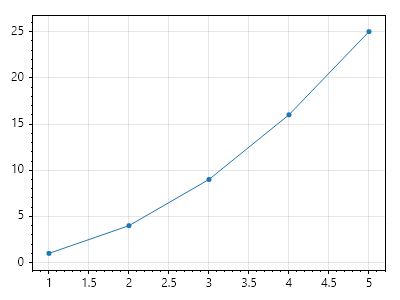

In [44]:
myPlot